# **COMP 6721 Applied Artificial Intelligence**
# **(Fall 2020)**
> Project Assignment Part I

# **AI Face Mask Detector**

## **Setup**

In [75]:
# Import required libraries
import torch 
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from sklearn.metrics import classification_report
import matplotlib.image as mpimg
import itertools
from sklearn.metrics import confusion_matrix

**D**ownloading data from Kaggle.com

In [76]:
# Getting data from kaggle.com
%%capture
# Keys for env - API
os.environ['KAGGLE_USERNAME'] = "karandeepbhardwaj" # username from the json file
os.environ['KAGGLE_KEY'] = "a188728f8e2873a3cd0394bd2b543ffb" # key from the json file

# Bash commands to download data and unzip in source directory
!kaggle datasets download -d andrewmvd/animal-faces
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip -d data_set
!unzip animal-faces.zip -d my_not_human_data
!rm -r sample_data
!rm animal-faces.zip
!rm face-mask-12k-images-dataset.zip

!mkdir "./myData"
!mkdir "./myData/Test"
!mkdir "./myData/Train"
!mkdir "./myData/Test/Mask"
!mkdir "./myData/Test/NoMask"
!mkdir "./myData/Test/NotHuman"

!mv "./data_set/Face Mask Dataset/Test/WithMask" "./myData/Test/Mask"
!mv "./data_set/Face Mask Dataset/Test/WithoutMask" "./myData/Test/NoMask"
!mv "./my_not_human_data/afhq/val/cat" "./myData/Test/NotHuman"

!mkdir "./myData/Train/Mask"
!mkdir "./myData/Train/NoMask"
!mkdir "./myData/Train/NotHuman"

!mv "./data_set/Face Mask Dataset/Train/WithMask" "./myData/Train/Mask"
!mv "./data_set/Face Mask Dataset/Train/WithoutMask" "./myData/Train/NoMask"
!mv "./my_not_human_data/afhq/train/cat" "./myData/Train/NotHuman"

!rm -r data_set
!rm -r my_not_human_data/

Paths to data folders created in source directory.

In [77]:
#Data Loading
classes = ['Masked', 'NotMasked', 'NotHuman']

maskPath = './myData/Train/Mask/'
nonMaskPath = './myData/Train/NoMask/'
nonHumanPath ='./myData/Train/NotHuman/'

testMask = './myData/Test/Mask/'
testNonMask = './myData/Test/NoMask/'
testNotHuman = './myData/Test/NotHuman/'

directories = {0:maskPath, 1:nonMaskPath, 2:nonHumanPath}
testDirectories = {0:testMask, 1:testNonMask , 2:testNotHuman}

**Data Extraction:** 
*   Extracting data from above defined paths.
*   Resizing Images.
*   Reading images from disk.
*   Writing to data as np array form to trainingData.


In [78]:
class PrepProcessingModel():
    IMAGESIZE = 100
    trainingData = []
    def makeDataSet(self, directoryType):
        for label, dataDirectory in directoryType.items():
            print('\n\n Currently reading Label: ',label,'\n')
            for folder in tqdm(os.listdir(dataDirectory)):
                folderPath = os.path.join(dataDirectory, folder);
                for imgpath in os.listdir(folderPath):
                    imagePath = os.path.join(folderPath, imgpath);
                    img = cv2.imread(imagePath);
                    img = cv2.resize(img, (self.IMAGESIZE,self.IMAGESIZE));
                    self.trainingData.append([np.array(img), label]);
        np.random.shuffle(self.trainingData)

Running PreProcessing to write image marked data to trainingData.

In [79]:
PrepProcessingModel = PrepProcessingModel()
PrepProcessingModel.makeDataSet(directories)
trainingData = PrepProcessingModel.trainingData

  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  0 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  1 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  2 



100%|██████████| 1/1 [00:30<00:00, 30.01s/it]

Labeling from Train Data:


# Creating test data set

In [80]:
PrepProcessingModel.makeDataSet(testDirectories)
testData = PrepProcessingModel.trainingData

  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  0 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  1 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  2 



100%|██████████| 1/1 [00:02<00:00,  2.86s/it]

Labeling from Test Data:


In [81]:
_, test_data = torch.utils.data.random_split(testData, [(len(testData) - 3000), 3000])

* **Creating Pytorch Dataset**

In [82]:
# Creating pytorch Dataset by converting training data set from preprocessing to tensor data type.
class BuildDataSet(Dataset):
        def __init__(self, train_data):
            self.train_data = train_data
            self.transformations = Compose([
                ToTensor(),
            ])
        
        def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('slicing is not supported')                    
            return [
                self.transformations(self.train_data[key][0]), torch.tensor(self.train_data[key][1])
            ]
        
        def __len__(self):
            return len(self.train_data)


> * Creating Training Data Loader
> * Creating validation Data Loader

In [83]:
myDataset = BuildDataSet(trainingData)
trainingData, validationData = torch.utils.data.random_split(myDataset, [(len(myDataset) - 3000), 3000])
batch_size = 32
trainDatLoader = DataLoader(trainingData, batch_size * 2, shuffle=True)
valDatLoader = DataLoader(validationData, batch_size * 2)

In [84]:
myTestDataSet = BuildDataSet(trainingData)

# **Accuracy**

In [85]:
# Calculating accuracy from dataset
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    true_positives_negatives = torch.sum(preds == labels).item()
    total_predictions = len(preds)
    result = true_positives_negatives/total_predictions
    accuracy = torch.tensor(result)
    return accuracy

# **CNN** Architecture

In [86]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch 
        return F.cross_entropy(self(images), labels.long())
    
    def validation_step(self, batch):
        images, labels = batch
        return {'val_loss': F.cross_entropy(self(images), labels.long()).detach(), 'val_acc': accuracy(self(images), labels)}
        
    def validation_epoch_end(self, outputs):

        batchLosses = []
        batchAccuracies = []
        for x in outputs:
            batchLosses.append(x['val_loss'])
            batchAccuracies.append(x['val_acc'])
        epochLosses = torch.stack(batchLosses).mean()
        epochAccuracies = torch.stack(batchAccuracies).mean()

        return {'val_loss': epochLosses.item(), 'val_acc': epochAccuracies.item()}
    
    def epoch_end(self, epoch, result):
        print("\n\nEpoch: [{}]\n\nTraining Data Loss: {:.4f}\nValidation Data Loss: {:.4f}\nValidation data Accuracy: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# **Convolution Neural Network**


*   Feature Learning
*   Classification



In [87]:
class CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            #First convolution layer
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),

            #Second convolution layer
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            #First pooling layer
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            #Third convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            #Fourth convolution layer
            # nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            # nn.ReLU(),

            #Second pooling layer
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            #Flattening and rectification
            nn.Flatten(), 
            nn.Linear(160000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3))
        
    def forward(self, xb):
      return self.network(xb)

**Checking the availability of GPU**
> If not present then use CPU

In [88]:
device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

> Move the tensor to chosen device for processing. (CPU or GPU)

In [89]:
def toDevice(data, device):
    if isinstance(data, (list, tuple)):
        myList = []
        for x in data:
            myList.append(toDevice(x, device))
        return myList
    return data.to(device, non_blocking=True)

# Overriding Dataloader methods
* Move data to device
* Yield a batch from device afterwards
* Get number of batches

In [90]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield toDevice(b, self.device)

    def __len__(self):
        return len(self.dl)

* Loading data to device

In [91]:
trainDatLoader = DeviceDataLoader(trainDatLoader, device)
valDatLoader = DeviceDataLoader(valDatLoader, device)

# **Training**

In [92]:
@torch.no_grad()
def evaluate(model, valLoader):
    model.eval()
    outputs = []
    for batch in valLoader:
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

> Train and Validate data from datasets

In [93]:
def fit(epochs, lr, model, trainLoader, valLoader, optFfunc=torch.optim.SGD):
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        trainLosses = []
        for batch in trainLoader:
            loss = model.training_step(batch)
            trainLosses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valLoader)
        result['train_loss'] = torch.stack(trainLosses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model (on GPU)

In [94]:
model = CNNModel()
toDevice(model, device);
model.eval();
history = [evaluate(model, valDatLoader)]
history
history = fit(15, 1e-3, model, trainDatLoader, valDatLoader)



Epoch: [0]

Training Data Loss: 0.9925
Validation Data Loss: 0.7028
Validation data Accuracy: 0.6987


Epoch: [1]

Training Data Loss: 0.4228
Validation Data Loss: 0.3092
Validation data Accuracy: 0.8788


Epoch: [2]

Training Data Loss: 0.2280
Validation Data Loss: 0.2569
Validation data Accuracy: 0.9085


Epoch: [3]

Training Data Loss: 0.1886
Validation Data Loss: 0.1668
Validation data Accuracy: 0.9399


Epoch: [4]

Training Data Loss: 0.1480
Validation Data Loss: 0.1482
Validation data Accuracy: 0.9450


Epoch: [5]

Training Data Loss: 0.1228
Validation Data Loss: 0.1238
Validation data Accuracy: 0.9519


Epoch: [6]

Training Data Loss: 0.1031
Validation Data Loss: 0.1751
Validation data Accuracy: 0.9306


Epoch: [7]

Training Data Loss: 0.0966
Validation Data Loss: 0.0981
Validation data Accuracy: 0.9595


Epoch: [8]

Training Data Loss: 0.0801
Validation Data Loss: 0.1088
Validation data Accuracy: 0.9545


Epoch: [9]

Training Data Loss: 0.0697
Validation Data Loss: 0.0937
Val

In [129]:
#saving to disk
torch.save(model.state_dict(), './MaskDetection.pth')

> # **Testing images after modeling.**

In [98]:
# Testing
def singleImage(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Image wasn't read properly"
    img = cv2.resize(img, (100, 100))
    img = torch.from_numpy(img)
    img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
    img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
    img = img.to('cuda') # Using the same device as the model
    pred = model(img)
    _, preds = torch.max(pred, dim=1)
    print(classes[preds.item()])
    
    if show:
        plt.imshow(mpimg.imread(path))
        print("the image is :" + classes[preds.item()])

In [99]:
def valImage(key, typeOfData):
    img = typeOfData[key][0]
    pred = model(img.unsqueeze(dim=0).to(device))
    _, preds = torch.max(pred, dim=1)
    return (typeOfData[key][1],preds.item())

# **Display Result**

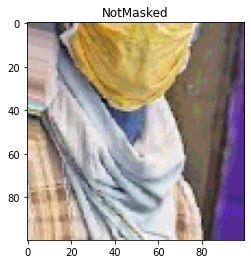

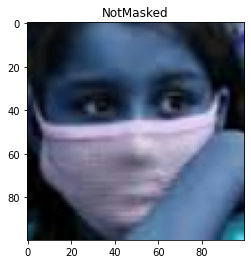

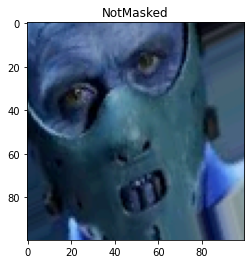

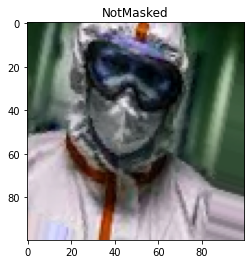

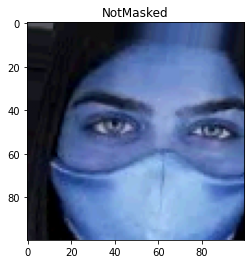

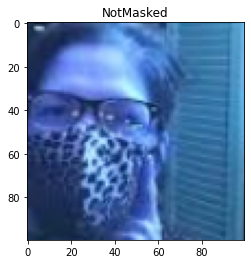

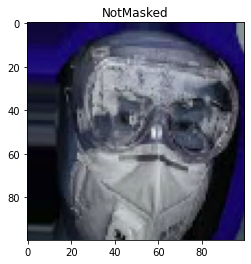

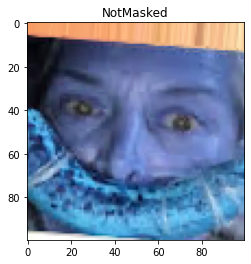

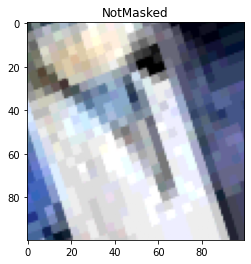

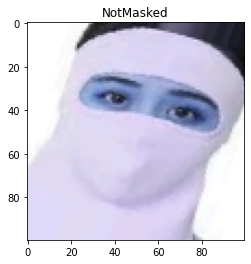

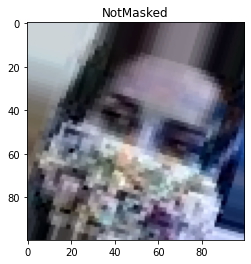

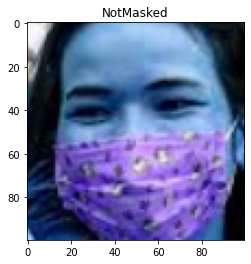

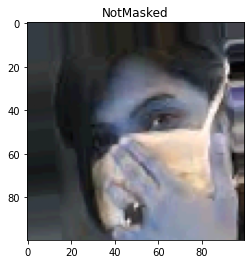

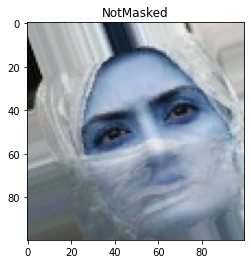

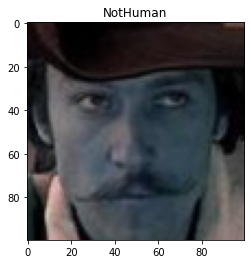

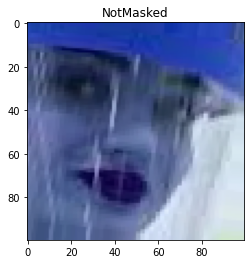

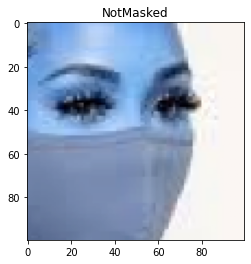

<Figure size 432x288 with 0 Axes>

In [113]:
y_pred = []
x_act = []
for x in range(1000):
  actual, predicted = valImage(x, myTestDataSet)
  y_pred.append(predicted)
  x_act.append(actual)
y_pred = np.asarray(y_pred)
x_act = np.asarray(x_act)

def show_example(data):
    img, label = data
    plt.title(classes[y_pred[label]])
    plt.imshow(img.permute(1, 2, 0))
    plt.figure()

output = []
y=0
for i in range(len(y_pred)): 
    if x_act[i] != y_pred[i]:
      output.append(i) 

for x in output:
  show_example(myTestDataSet[x])

In [101]:
def plotConfusionMatrix(confmat, classes, normalize=False, title='Confusion matrix', confmap=plt.confmat.Blues):
    if normalize:
        confmat = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(confmat)
    plt.imshow(confmat, interpolation='nearest', cmap=confmap)
    plt.title(title)
    plt.colorbar()
    tickMarks = np.arange(len(classes))
    plt.xticks(tickMarks, classes, rotation=45)
    plt.yticks(tickMarks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confmat.max() / 2.
    for i, j in itertools.product(range(confmat.shape[0]), range(confmat.shape[1])):
        plt.text(j, i, format(confmat[i, j], fmt), horizontalalignment="center", color="white" if confmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[308   0   0]
 [  8 318   0]
 [  8   1 357]]


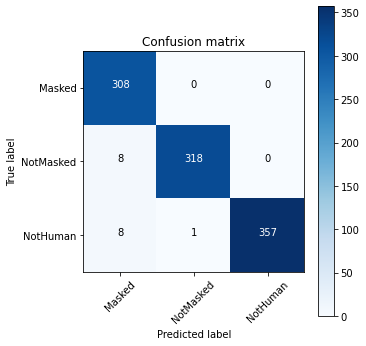

In [102]:
confmat = confusion_matrix(y_pred, x_act)
plt.figure(figsize=(5,5))
plotConfusionMatrix(confmat, classes);

In [103]:
all_scores = classification_report(y_pred, x_act)
print(all_scores)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       308
           1       1.00      0.98      0.99       326
           2       1.00      0.98      0.99       366

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

